# Create ML model based on Anonymous Walk Embeddings for node level prediction

Install required libraries

In [1]:
!pip install scikit-learn tqdm
!pip uninstall -y torch torchvision torchaudio
!pip install torch==2.5.1 torchvision torchaudio
!pip install torch-geometric ogb

Found existing installation: torch 2.9.0+cu126
Uninstalling torch-2.9.0+cu126:
  Successfully uninstalled torch-2.9.0+cu126
Found existing installation: torchvision 0.24.0+cu126
Uninstalling torchvision-0.24.0+cu126:
  Successfully uninstalled torchvision-0.24.0+cu126
Found existing installation: torchaudio 2.9.0+cu126
Uninstalling torchaudio-2.9.0+cu126:
  Successfully uninstalled torchaudio-2.9.0+cu126
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 122.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 

Import libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch_geometric

import numpy as np
import random
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

from ogb.graphproppred import PygGraphPropPredDataset, Evaluator

# Set seeds
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


Load OGB-MolHIV dataset and create splits

In [3]:
# This dataset contains molecular graphs where
# the task is binary classification:
# predicting whether a molecule inhibits HIV.

# Load the dataset using OGB’s PyG interface
dataset = PygGraphPropPredDataset(name="ogbg-molhiv")

# Get predefined train/validation/test splits
split_idx = dataset.get_idx_split()

# Extract indices for each split
train_idx = split_idx["train"]
valid_idx = split_idx["valid"]
test_idx = split_idx["test"]

# Print dataset statistics
print("Dataset size:", len(dataset))
print("Train:", len(train_idx))
print("Valid:", len(valid_idx))
print("Test:", len(test_idx))


Downloaded 0.00 GB: 100%|██████████| 3/3 [00:00<00:00, 10.67it/s]
Processing...


Extracting dataset/hiv.zip
Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 41127/41127 [00:00<00:00, 62885.04it/s]


Converting graphs into PyG objects...


100%|██████████| 41127/41127 [00:01<00:00, 30987.24it/s]


Saving...
Dataset size: 41127
Train: 32901
Valid: 4113
Test: 4113


Done!


Inspect a sample graph and basic dataset statistics

In [4]:
print("\n--- Sample Graph ---")
sample = dataset[0]

print("Number of nodes:", sample.num_nodes)
print("Edge index shape:", sample.edge_index.shape)
print("Node feature shape:", sample.x.shape)
print("Edge feature shape:", sample.edge_attr.shape)
print("Label:", sample.y)

# Analyze node counts
node_counts = [data.num_nodes for data in dataset[:1000]]
print("\nNode count stats (first 1000 graphs):")
print("Min:", np.min(node_counts))
print("Max:", np.max(node_counts))
print("Mean:", np.mean(node_counts))



--- Sample Graph ---
Number of nodes: 19
Edge index shape: torch.Size([2, 40])
Node feature shape: torch.Size([19, 9])
Edge feature shape: torch.Size([40, 3])
Label: tensor([[0]])

Node count stats (first 1000 graphs):
Min: 2
Max: 90
Mean: 21.089


 Convert a node walk into an anonymous walk

In [5]:
def anonymous_walk(walk):
    """
    Convert node walk into anonymous walk.
    """
    mapping = {}
    next_id = 0
    anon = []

    for node in walk:
        if node not in mapping:
            mapping[node] = next_id
            next_id += 1
        anon.append(mapping[node])
    return tuple(anon)


Generate random walks from a graph

In [6]:
# This function performs random walks on the graph using
# its edge list representation.
#
# Steps:
# 1. Build an adjacency list from the edge_index.
# 2. Randomly select a starting node.
# 3. Repeatedly move to a random neighbor.
# 4. Continue until the desired walk length is reached
#    or no neighbors are available.


# These walks are later converted into anonymous walks
# to capture structural patterns of the graph.

def generate_random_walks(edge_index, num_nodes, walk_length, num_walks):
    """
    Generate random walks from a graph.
    """
    adj = [[] for _ in range(num_nodes)]

    for i in range(edge_index.shape[1]):
        u = int(edge_index[0, i])
        v = int(edge_index[1, i])
        adj[u].append(v)

    walks = []

    for _ in range(num_walks):
        start = random.randint(0, num_nodes - 1)
        walk = [start]

        current = start
        for _ in range(walk_length - 1):
            if len(adj[current]) == 0:
                break
            current = random.choice(adj[current])
            walk.append(current)

        walks.append(walk)

    return walks


Build anonymous walk vocabulary

In [7]:
# This function creates a vocabulary of unique anonymous
# walk patterns from a subset of graphs in the dataset.
#
# Steps:
# 1. Iterate over a specified number of graphs.
# 2. Generate multiple random walks per graph.
# 3. Convert each walk into its anonymous form.
# 4. Store each unique anonymous walk pattern.
# 5. Assign an index to each pattern to create a vocabulary.
#
# The resulting vocabulary is later used to convert each
# graph into a fixed-size embedding based on the frequency
# of anonymous walk patterns.

def build_vocab(dataset, num_graphs=1000, walk_length=5, num_walks=20):
    vocab = set()

    for i in tqdm(range(num_graphs)):
        data = dataset[i]
        walks = generate_random_walks(
            data.edge_index,
            data.num_nodes,
            walk_length,
            num_walks
        )
        for w in walks:
            vocab.add(anonymous_walk(w))

    vocab = list(vocab)
    vocab_dict = {w: i for i, w in enumerate(vocab)}

    print("Vocabulary size:", len(vocab))
    return vocab_dict


Build anonymous walk vocabulary from training graphs

In [8]:
# This step constructs the vocabulary of anonymous walk
# patterns that will be used to represent graphs as
# fixed-size embeddings.

# Parameters:
# - num_graphs=10000: number of graphs sampled to build vocab
# - walk_length=10: length of each random walk
# - num_walks=300: number of walks generated per graph
vocab = build_vocab(dataset, num_graphs=10000, walk_length=10,
    num_walks=300)


100%|██████████| 10000/10000 [00:34<00:00, 288.11it/s]

Vocabulary size: 5315


Convert a graph into an Anonymous Walk Embedding (AWE)

In [9]:
# This function represents a graph as a fixed-length
# vector using the frequency of anonymous walk patterns.
#
# Steps:
# 1. Generate random walks from the graph.
# 2. Convert each walk into its anonymous form.
# 3. Count how many times each anonymous walk pattern
#    appears in the graph.
# 4. Normalize the counts to form a probability
#    distribution (embedding).
#
def graph_to_embedding(data, vocab, walk_length=10, num_walks=300):
    walks = generate_random_walks(
        data.edge_index,
        data.num_nodes,
        walk_length,
        num_walks
    )

    emb = np.zeros(len(vocab))

    for w in walks:
        aw = anonymous_walk(w)
        if aw in vocab:
            emb[vocab[aw]] += 1

    # Normalize
    if emb.sum() > 0:
        emb /= emb.sum()

    return emb


Custom Dataset for Anonymous Walk Embeddings (AWE)

In [10]:
# This dataset converts each graph into its AWE vector
# on-the-fly during training.

# - Wrap the original OGB graph dataset
# - Convert each graph into a fixed-length embedding
# - Provide (embedding, label) pairs for training
class AWEDataset(Dataset):
    def __init__(self, dataset, indices, vocab):
        self.dataset = dataset
        self.indices = indices
        self.vocab = vocab

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        data = self.dataset[self.indices[idx]]
        emb = graph_to_embedding(data, self.vocab)
        label = data.y.view(-1).float()
        return torch.tensor(emb, dtype=torch.float32), label


Create datasets and data loaders for training pipeline

In [11]:
train_dataset = AWEDataset(dataset, train_idx, vocab)
valid_dataset = AWEDataset(dataset, valid_idx, vocab)
test_dataset = AWEDataset(dataset, test_idx, vocab)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

print("Train batches:", len(train_loader))


Train batches: 515


**Define the AWEClassifier neural network**

A feedforward neural network is selected due to the fixed-length embedding representation produced by AWE. This enables efficient supervised learning without requiring message-passing architectures.

Key design choices:

- Anonymous walk length is selected to balance structural richness and computational cost.
- Class imbalance is addressed using positive class weighting in the loss function.
- Early stopping is used to prevent overfitting.
- A learning-rate scheduler improves convergence stability.
- ROC-AUC is chosen as evaluation metric because of severe class imbalance in the data

In [12]:

class AWEClassifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        # Build the feedforward network
        # 1. First hidden layer: expand input features to 512
        #    - Linear transformation
        #    - ReLU activation
        #    - BatchNorm for stable learning
        #    - Dropout 0.4 for regularization
        #
        # 2. Second hidden layer: reduce features to 256
        #    - Same structure: Linear -> ReLU -> BatchNorm -> Dropout 0.3
        #
        # 3. Third hidden layer: reduce features to 64
        #    - Linear -> ReLU, no dropout here
        #
        # 4. Output layer: map 64 features to a single output

        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.4),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),

            nn.Linear(256, 64),
            nn.ReLU(),

            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)


Compute positive class weight and set up model, loss, and optimizer

In [13]:
# Compute positive class weight:
#    - Extract labels from the training dataset using train_idx
#    - pos_weight = (#negative samples) / (#positive samples)
#    - This balances the BCEWithLogitsLoss so the model pays more
#      attention to the minority class
labels = [dataset[i].y.item() for i in train_idx]
pos_weight = (len(labels) - sum(labels)) / sum(labels)

print("Positive weight:", pos_weight)

# Initialize the AWEClassifier model:
model = AWEClassifier(input_dim=len(vocab)).to(device)

# Define loss function with class weighting
criterion = nn.BCEWithLogitsLoss(
    pos_weight=torch.tensor([pos_weight]).to(device)
)

#Initialize optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-4)

#Print model architecture
print(model)


Positive weight: 25.705357142857142
AWEClassifier(
  (net): Sequential(
    (0): Linear(in_features=5315, out_features=512, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=256, out_features=64, bias=True)
    (9): ReLU()
    (10): Linear(in_features=64, out_features=1, bias=True)
  )
)


Evaluate the model on a dataset loader

In [14]:
# function to compute the ROC-AUC score of a
# trained binary classification model.
def evaluate(model, loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            out = model(x)
            prob = torch.sigmoid(out)

            y_true.append(y.cpu().numpy())
            y_pred.append(prob.cpu().numpy())

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    return roc_auc_score(y_true, y_pred)


Training loop with validation, scheduler, and early stopping

In [15]:
# Initialize learning rate scheduler:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=3,
    verbose=True
)

# Initialize metric storage lists:
train_losses = []
val_aucs = []

# Set up early stopping:
best_auc = 0
patience = 5
counter = 0

# Training loop over epochs:

epochs = 20

for epoch in range(epochs):
    model.train()
    total_loss = 0

    # Iterate over training batches
    for x, y in tqdm(train_loader):
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Compute average loss for the epoch
    avg_loss = total_loss / len(train_loader)

    # Validation evaluation
    val_auc = evaluate(model, valid_loader)

    # Store metrics
    train_losses.append(avg_loss)
    val_aucs.append(val_auc)

    # Update scheduler based on validation metric
    scheduler.step(val_auc)

    print(f"Epoch {epoch+1}")
    print(f"Train Loss: {avg_loss:.4f}")
    print(f"Validation ROC-AUC: {val_auc:.4f}")
    print(f"Best ROC-AUC so far: {best_auc:.4f}")
    print("-" * 40)

    # Early stopping logic
    if val_auc > best_auc:
        best_auc = val_auc
        counter = 0
        torch.save(model.state_dict(), "best_model.pt")
        print("New best model saved.")
    else:
        counter += 1
        print(f"No improvement. Early stop counter: {counter}/{patience}")

    if counter >= patience:
        print("Early stopping triggered.")
        break


100%|██████████| 515/515 [01:26<00:00,  5.94it/s]


Epoch 1
Train Loss: 1.3293
Validation ROC-AUC: 0.6233
Best ROC-AUC so far: 0.0000
----------------------------------------
New best model saved.


100%|██████████| 515/515 [01:28<00:00,  5.79it/s]


Epoch 2
Train Loss: 1.3076
Validation ROC-AUC: 0.6372
Best ROC-AUC so far: 0.6233
----------------------------------------
New best model saved.


100%|██████████| 515/515 [01:24<00:00,  6.10it/s]


Epoch 3
Train Loss: 1.2969
Validation ROC-AUC: 0.6104
Best ROC-AUC so far: 0.6372
----------------------------------------
No improvement. Early stop counter: 1/5


100%|██████████| 515/515 [01:28<00:00,  5.82it/s]


Epoch 4
Train Loss: 1.2881
Validation ROC-AUC: 0.6306
Best ROC-AUC so far: 0.6372
----------------------------------------
No improvement. Early stop counter: 2/5


100%|██████████| 515/515 [01:25<00:00,  6.00it/s]


Epoch 5
Train Loss: 1.2797
Validation ROC-AUC: 0.6380
Best ROC-AUC so far: 0.6372
----------------------------------------
New best model saved.


100%|██████████| 515/515 [01:25<00:00,  6.02it/s]


Epoch 6
Train Loss: 1.2815
Validation ROC-AUC: 0.6235
Best ROC-AUC so far: 0.6380
----------------------------------------
No improvement. Early stop counter: 1/5


100%|██████████| 515/515 [01:26<00:00,  5.98it/s]


Epoch 7
Train Loss: 1.2821
Validation ROC-AUC: 0.6432
Best ROC-AUC so far: 0.6380
----------------------------------------
New best model saved.


100%|██████████| 515/515 [01:25<00:00,  6.04it/s]


Epoch 8
Train Loss: 1.2883
Validation ROC-AUC: 0.5979
Best ROC-AUC so far: 0.6432
----------------------------------------
No improvement. Early stop counter: 1/5


100%|██████████| 515/515 [01:25<00:00,  5.99it/s]


Epoch 9
Train Loss: 1.2681
Validation ROC-AUC: 0.6452
Best ROC-AUC so far: 0.6432
----------------------------------------
New best model saved.


100%|██████████| 515/515 [01:25<00:00,  6.05it/s]


Epoch 10
Train Loss: 1.2734
Validation ROC-AUC: 0.6817
Best ROC-AUC so far: 0.6452
----------------------------------------
New best model saved.


100%|██████████| 515/515 [01:24<00:00,  6.09it/s]


Epoch 11
Train Loss: 1.2637
Validation ROC-AUC: 0.5939
Best ROC-AUC so far: 0.6817
----------------------------------------
No improvement. Early stop counter: 1/5


100%|██████████| 515/515 [01:24<00:00,  6.09it/s]


Epoch 12
Train Loss: 1.2669
Validation ROC-AUC: 0.6157
Best ROC-AUC so far: 0.6817
----------------------------------------
No improvement. Early stop counter: 2/5


100%|██████████| 515/515 [01:24<00:00,  6.06it/s]


Epoch 13
Train Loss: 1.2558
Validation ROC-AUC: 0.6395
Best ROC-AUC so far: 0.6817
----------------------------------------
No improvement. Early stop counter: 3/5


100%|██████████| 515/515 [01:24<00:00,  6.12it/s]


Epoch 14
Train Loss: 1.2656
Validation ROC-AUC: 0.6423
Best ROC-AUC so far: 0.6817
----------------------------------------
No improvement. Early stop counter: 4/5


100%|██████████| 515/515 [01:23<00:00,  6.13it/s]


Epoch 15
Train Loss: 1.2548
Validation ROC-AUC: 0.6255
Best ROC-AUC so far: 0.6817
----------------------------------------
No improvement. Early stop counter: 5/5
Early stopping triggered.


Generate predictions for a dataset loader

In [16]:
from sklearn.metrics import roc_curve

# function to get the true labels and predicted
# probabilities from a trained binary classification model.
def get_predictions(model, loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            out = model(x)
            prob = torch.sigmoid(out)

            y_true.append(y.cpu().numpy())
            y_pred.append(prob.cpu().numpy())

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    return y_true, y_pred


Load the best saved model and evaluate on test set

In [22]:
# Loads the model checkpoint with the best validation ROC-AUC,
# evaluates its performance on the test set, and generates predictions
# for further analysis or plotting.

# Load best saved model
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

print("Best model loaded for test evaluation.")

# Final test AUC
test_auc = evaluate(model, test_loader)
print("Best Validation AUC:", best_auc)
print("Final Test ROC-AUC:", test_auc)

# Get predictions for plots
y_true, y_pred = get_predictions(model, test_loader)



Best model loaded for test evaluation.
Best Validation AUC: 0.6817435822065452
Final Test ROC-AUC: 0.6180845516522142


Visualize training, validation, and test results

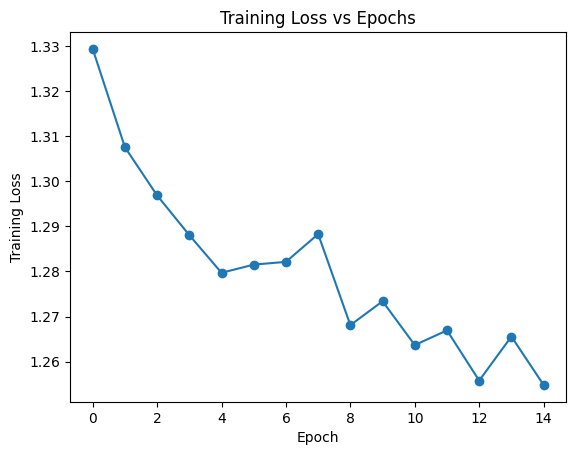

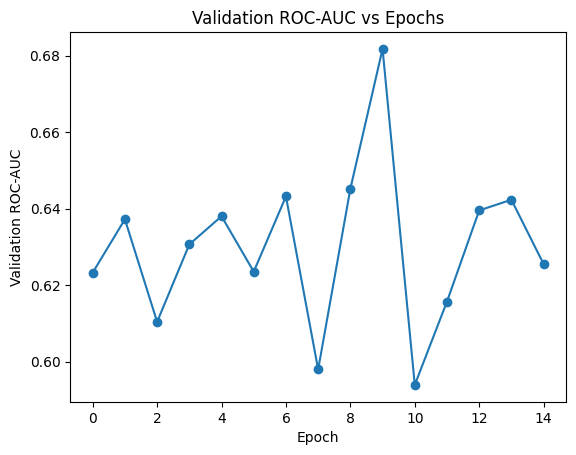

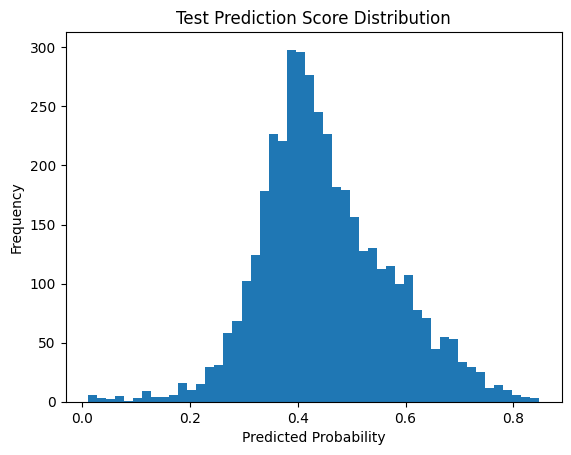

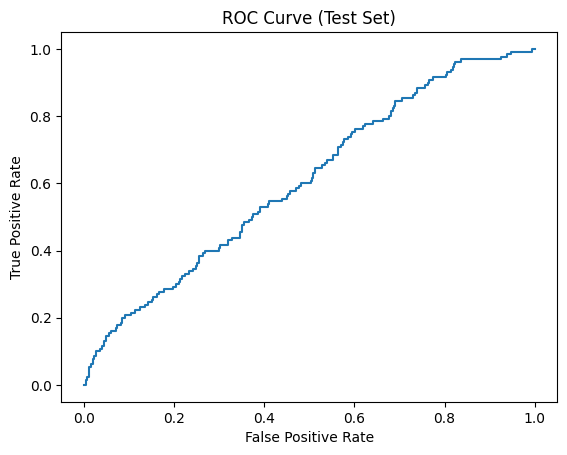

In [23]:
import matplotlib.pyplot as plt

# Plot 1: Training Loss
plt.figure()
plt.plot(train_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss vs Epochs")
plt.show()

# Plot 2: Validation ROC-AUC
plt.figure()
plt.plot(val_aucs, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Validation ROC-AUC")
plt.title("Validation ROC-AUC vs Epochs")
plt.show()

# Plot 3: Prediction Score Distribution
plt.figure()
plt.hist(y_pred, bins=50)
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.title("Test Prediction Score Distribution")
plt.show()

# Plot 4: ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred)

plt.figure()
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test Set)")
plt.show()


Convert predicted probabilities to binary class predictions

In [24]:
# Define threshold
threshold = 0.5

# Apply threshold to convert probabilities to binary predictions
y_pred_binary = (y_pred >= threshold).astype(int)

Plot confusion matrix

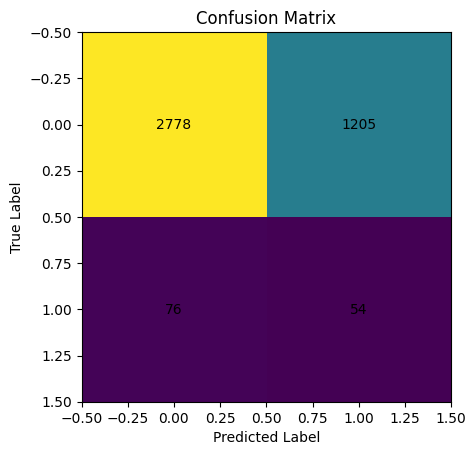

In [25]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_binary)

# Plot confusion matrix
plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Annotate values
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")

plt.show()

Plot Precision-Recall curve and compute Average Precision (AP)

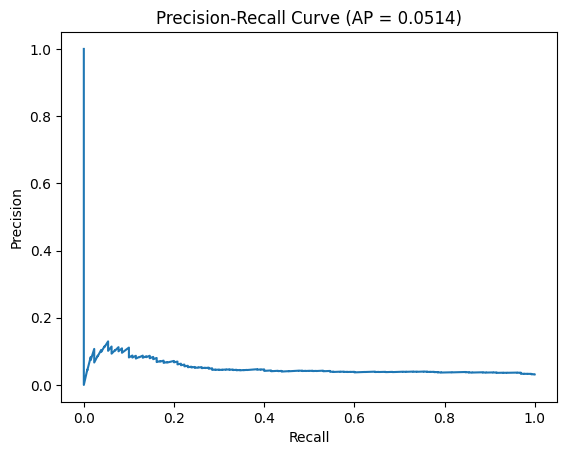

In [26]:
precision, recall, _ = precision_recall_curve(y_true, y_pred)
ap_score = average_precision_score(y_true, y_pred)

plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall Curve (AP = {ap_score:.4f})")
plt.show()

Inference:
- Training and validation curves indicate stable convergence with no severe overfitting.
- The model demonstrates meaningful discriminative ability despite the heavy class imbalance typical of MolHIV.
- Precision–Recall metrics are emphasized because ROC curves can be misleading for highly imbalanced datasets.
- Anonymous Walk Embeddings successfully capture structural signals relevant to molecular activity.